# Markov State Modeling

## Due Date: 5/16/19

In this module, you will investigate a very typical chemical test system, the alanine dipeptide, by creating a Markov State Model (MSM). MSMs rely on the Markov assumption, meaning at any given timepoint, the future state of the system only depends on the current state of the system - *i.e.* the process does not have memory. As discussed in class, making an MSM corresponds to solving a master equation that approximates the dynamics of a system. This makes it possible to extract long-time kinetic information for processes that occur beyond the timescales of typical molecular dynamics.

The [alanine dipeptide](https://pubs.acs.org/doi/abs/10.1021/jp048540w) is one of the most tested systems in chemical simulation, as it is a [small system, easily controlled by few variables](https://www.pnas.org/content/108/8/3095), that has non-trivial energetic and kinetic properties. Because it is so well-characterized, it is often a useful system on which to test new techniques. Here, we will use MSMs to find the mechanism of a specific rotation in ADP. One could run many long MD trajectories to build up statistics for this transition, but that would be very computationally costly. Instead, we will uses MSMs to gather this information from one relatively short trajectory. 

Before we get started with this, however, we need to download all the needed software and data.

# Downloading PyEMMA

The software package we will be using to create the MSM is [PyEMMA](http://emma-project.org/latest/index.html), a python package developed specifically for Markov State Modeling. For instillation, follow the process described on the [PyEMMMA github](https://github.com/markovmodel/PyEMMA) - specifically, since you should all have Anaconda installed already, you should use the command `conda install -c conda-forge pyemma`. 

In this module, we will broadly be following the procedure described in the [first PyEMMA tutorial](http://emma-project.org/latest/generated/00-pentapeptide-showcase.html), with a few substitutions and modifications. Most of the code/syntax you will need is available in that tutorial, or the others in the tutorial section - however, I encourage you to not simply copy their code. You will get the most out of this module if you think through all of the choices made in the process of constructing an MSM. The tutorials are meant to be used as a reference for general PyEMMA syntax - if you find you don't know how to generate the graphs/data asked for in this module, **check the tutorials for examples**. It will also be useful to explore the [documentation](http://emma-project.org/latest/api/index.html) to find out what each individual function is doing. 

To that end, it will be useful for you to [download](https://github.com/markovmodel/PyEMMA_tutorials) the tutorials as well - this will allow you to run the tutorials on your local machine, and the github package has some useful tools bundled with it that we will be using in this module. Again, since you already have Anaconda installed, you should run `conda install -c conda-forge pyemma_tutorials` to install all the needed packages. The tutorials themselves can be opened with Jupyter Notebook as usual.


# Accessing the Alanine Dipeptide Data

You will not be running your own molecular dynamics simulation for this module. Instead, you will be downloading the data from a 100 ns NVT (constant Number of particles, Volume, and Temperature) simulation of alanine dipeptide. This data is uploaded to Midway at `project2/chem37300/MSM_data` - you should download this folder to your local machine. To do this, navigate to the location where you will be completing the assignment on your local machine (where this .ipynb file is located), and run the following command:

`scp -r YOUR_CNET_ID@midway2.rcc.uchicago.edu:/project2/chem37300/MSM_data .`

This will place the data folder in your current directory. This folder contains three files. 

`adp_cvs.npy` - A binary, python-readable file that contains the backbone dihedrals, $\Phi$ and $\Psi$, for the trajectory. We will only be using this to initially visualize the data.

`adp_struc.gro` - This is the structure file for alanine dipeptide in `.gro` format, which is the default structure format for the popular MD engine GROMACS (the software used to generate this data). This file contains, among other things, all of the initial atomic identities and positions that will be needed to process the data. Another common structure file type is a `.pdb` file.

`adp_traj.xtc` - This is the compressed trajectory of the 100 ns simulation. This file contains 200,000 steps of the simulation, captured with a 0.5 ps timestep, making for 100 ns of overall simulation time. 

# Downloading/Using VMD

Finally, it will be useful for you to actually visualize some of the structures you are analyzing. One of the most common softwares that does this is [VMD](https://www.ks.uiuc.edu/Research/vmd/). If you want, you can download this on your local machine. Otherwise, you can use the version on Midway. You will have to log in via [ThinLinc](https://midway-login1.rcc.uchicago.edu/main/), as this gives you a GUI interface. Open a terminal, type `module load vmd`, and then navigate to where your structure/trajectory files are located. This might either be in the `MSM_data` folder, or in your own personal directory. Feel free to make a directory to store files in `project2/chem37300/`. To visualize a structure/trajectory, simply type `vmd FILE_NAME`. *Note:* `.xtc` files can't be visualized alone - instead, you must load them alongside a structure file. For example, to visualize the trajectory we will be analyzing in his module, you should navigate to `project2/chem37300/MSM_data`, and then type:

`vmd adp_struc.gro adp_traj.xtc`

This should load the trajectory in a pop-up visualization window. The default visualization scheme, however, can be a bit hard to parse. Instead, from the `VMD Main` window, navigate to `Graphics -> Representations`. From there, you can change the Drawing Method to something more natural for the alanine dipeptide system - I recommend Licorice. You can play around with this, as well as the coloring scheme. 

To manipulate the structure itself, you can zoom in and out with a normal scroll, and rotate the structure by clicking and dragging. You can hit the play button in the bottom right corner of the VMD window to animate your trajectory, controlling the speed with the adjacent bar. There are many, many other functionalities, but this should be enough to get you started. 

You should notice that the structures in this trajectory are all overlaid on one another - the dipeptide structure has already been aligned to a reference structure, eliminating COM translational and rotational motion. This allows for easier visualization, and easier feature selection (we will use this later).

If you want to view any structures generated from this tutorial, simply upload to Midway using `scp`, and then visualize them using VMD.

# Importing Packages

Hopefully this next step works. If not, your PyEMMA installation is likely incorrect. Make sure you followed the installation directions as given above. If the next block still doesn't work, feel free to e-mail a TA to get some help. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pyemma
from pyemma.util.contexts import settings

In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# Plotting Dihedral Data

First, initially plot the backbone dihedrals to see where we have sampling. Use the code below to plot this backbone data that is in `adp_cvs.npy`. You should see four natural clusters in the data. In this module, we want to find the mechanism of transition between the central left cluster and the lower right cluster. 

Looking at this data, why might this be difficult without making an MSM?

Text(0, 0.5, '$\\Psi$ (rad)')

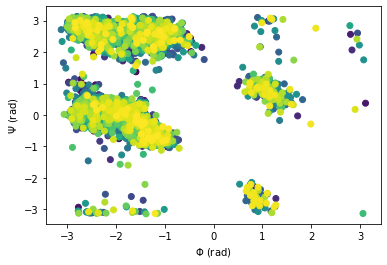

In [4]:
dh_traj = np.load('MSM_data/adp_cvs.npy')[:, 1:3]
plt.scatter(dh_traj[:,0][::100], dh_traj[:,1][::100], c=np.arange(len(dh_traj))[::100])
plt.xlabel(r'$\Phi$ (rad)')
plt.ylabel(r'$\Psi$ (rad)')

The sampling between the desired clusters seems separated by a large area where we do not have sampling. This means that we likely don't have statistics on a direct transition between these two regions. In order to gather that data to then draw conclusions as to the mechanism, we would need to run a lot more sampling, which could prove very computationally costly. While it may be possible to get this information via direct sampling for a simple system like alanine dipeptide, this problem quickly becomes intractable as you expand to larger, more complex systems.

# PyEMMA Featurizer - Dihedral Data 

The above procedure works well if you have already extracted variables from your simulation. However, what if you only have a trajectory in Cartesian coordinates? For this, we will use the `featurizer` in PyEMMA. This loads a structure file, extracts variables of interest from a trajectory, and then loads that data into memory for later use. As an example, here is how to use the featurizer to get much the same graph you obtained in the previous section.

In [5]:
# Create the featurizer and load the alanine dipeptide structure file
feat = pyemma.coordinates.featurizer('MSM_data/adp_struc.gro')

#Define the trajectory file 
dfile = 'MSM_data/adp_traj.xtc'

#Add the backbone dihedral data to the featurizer by using the featurizer's add_backbone_torsions() tool
feat.add_backbone_torsions(periodic=False)  #Note: Periodic=False because we aligned our trajectory to a reference
                                            #structure, thereby destroying the PBCs that were used in the simulation
    
#Load the backbone dihedral data into memory
#Note the slight difference from the PyEMMA tutorial:
#Because we only have one trajectory, one needs to create the data as a list, so the [] are neccessary here
data = [pyemma.coordinates.load(dfile, features=feat)]

In [2]:
#See how the data strucutres are defined. 
#Here, `data` is what we will feed into all the PyEMMA functions for analysis
#In contrast, `data_concatenated` is useful for plotting

print('Data ---------------------')
print('type of data:', type(data))
print('lengths:', len(data))
print('shape of elements:', data[0].shape)
print(feat.describe())

data_concatenated = np.concatenate(data)

print('Data Concatenated---------')
print('type of data:', type(data_concatenated))
print('lengths:', len(data_concatenated))
print('shape of elements:', data_concatenated[0].shape)
print(feat.describe())

Data ---------------------


NameError: name 'data' is not defined

In [7]:
print(data_concatenated)

[[-2.7475665  2.950342 ]
 [-2.8365076  2.8915343]
 [-2.5692234  3.085927 ]
 ...
 [ 1.0607549 -2.9731534]
 [ 1.0876749  3.1140916]
 [ 0.9819659  3.0034518]]


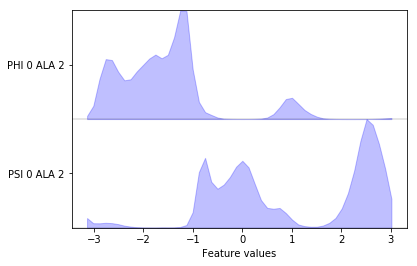

In [6]:
#Histogram our feature values using PyEMMAs plot_feature_histograms() tool
#Here, the feature values are just the backbone dihedrals in radians
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat);

Text(0, 0.5, '$\\Psi$ (rad)')

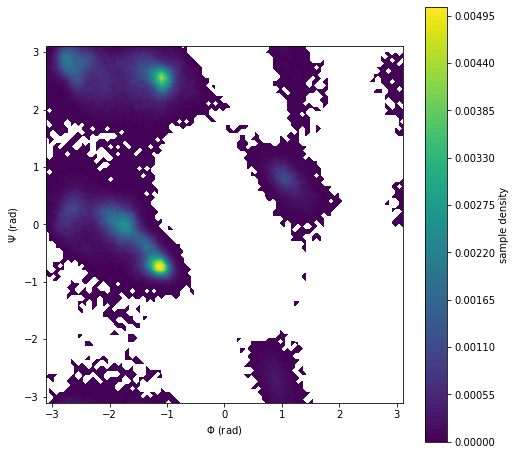

In [10]:
#Plot a histogram of the sampling in the trajectory by using PyEMMA's plot_density() tool

fig, ax = plt.subplots(figsize=(8, 8))
# the * operator used in a function call is used to unpack
# the iterable variable into its single elements. 
pyemma.plots.plot_density(*data_concatenated.T, ax=ax)

ax.set_xlabel('$\Phi$ (rad)')
ax.set_aspect('equal')
ax.set_ylabel('$\Psi$ (rad)')


Does this qualitatively agree with the plot from the previous section? 

Seems to! Areas of high and low density are reflected in both graphs.

# PyEMMA Featurizer - Backbone Data

In the case of alanine dipeptide, we knew that the backbone dihedrals are two variables that describe the system well. However, a good choice of variables is often not known *a priori*. Instead, one typically starts with some large variable space that likely describes processes of interest, and then uses a dimensionality reduction technique to reduce that large, complex state space into a smaller *collective variable* space. This reduced space will be easier to both model and visualize.

In this case, it is reasonable to assume that the positions of all of the atoms in the backbone of alanine dipeptide (that is, the carbons and nitrogens not in the side chains) encode most of the information about the system. 

In the following section, use the method described previously to load the backbone positions of the alanine dipeptide trajectory. What is the dimensionality of this data set? 

In [8]:
#Make the featurizer
positions_feat = pyemma.coordinates.featurizer('MSM_data/adp_struc.gro')

#Add the backbone positions using the featurizer's add_selection() and select_Backbone() tools
positions_feat.add_selection(positions_feat.select_Backbone())

#Load the backbone positions into memory
positions_data = [pyemma.coordinates.load('MSM_data/adp_traj.xtc', features=positions_feat)]


print('type of data:', type(positions_data))
print('lengths:', len(positions_data))
print('shape of elements:', positions_data[0].shape)

type of data: <class 'list'>
lengths: 1
shape of elements: (200001, 12)


# Dimensionality Reduction: Time-lagged Independent Component Analysis (TICA) 

The data set you just loaded should be relatively high-dimensional. In order to more easily work with these data, one should reduce the dimensionality of the problem. This is done by taking a linear transformation of the input coordinates, such that the autocorrelation of the output coordinates (of a lower dimension) is maximized. More information can be found [here](http://docs.markovmodel.org/lecture_tica.html). 

By default, TICA will output as many dimensions as is needed to maximize the autocorrelation. You can specify the number of dimensions desired by passing `dim = #_OF_DIMENSIONS`  to the pyemma.coordinates.tica() tool. TICA also requires a specific lag time, which is the number of timesteps that will separate the points in the trajectory to be compared in the autocorrelation maximizing step. Choosing an appropriate lag time is one of the biggest challenges both in MSMs and TICA, and there is no one perfect way to do it. 

One way to get an idea of the lag times desired for TICA is to look at the eigenvalues of the TICA transformation as a function of lag time. The dominant (largest) eigenvalues tell you about the slowest modes of the system - these are the modes that we care about, and the ones we are trying to model. This is shown below

In [9]:
#Import the package we will use for the eigensolve
import scipy.linalg as spl

#Define the time lags at which to run TICA
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000 , 2000, 5000, 10000]

eigs_4d = []

#Loop through the time lags
for lag in lags:
    #Perform the dimensionality reduction, obtain the transform itself
    tica_4d = pyemma.coordinates.tica(positions_data, lag=lag, dim = 4)
    #Find the eigenvalues of the transform
    evals_4d = spl.eigh(tica_4d.cov_tau, tica_4d.cov, eigvals_only=True)
    eigs_4d.append(evals_4d)

Text(0, 0.5, 'TICA Eigenvalues')

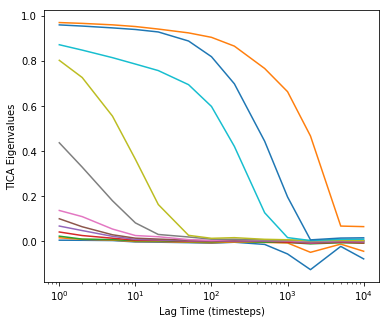

In [10]:
#Plot the TICA Eigenvalues as a function of lag time 
eigs_4d = np.array(eigs_4d)
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.array(lags), eigs_4d)
ax.set_xscale('log')
ax.set_xlabel('Lag Time (timesteps)')
ax.set_ylabel('TICA Eigenvalues')

You should find that all but four eigenvalues converge to near-zero for a 20 step lag time, and all but 3 converge to near-zero for a 100 step lag time. Run TICA with both a 20-step and a 100-step lag time, and compare your results. You should took at your TICA feature histograms, your density plots in TICA space, and your TICA trajectories through time. There are examples in the PyEMMA tutorial for how to do all of these. Use these plots, and the one you just created, to answer the following questions:

What are the differences in the dimensionality of the TICA results (eigenvectors and eigenvalues) as you increase lag time? Why is that the case?

Are your density projections in TICA space consistent with your projections into dihedral/Ramachandran space? How can you tell? Why do your TICA trajectories look the way they do?

Also, project each of your TICA outputs onto the $\Phi$ vs. $\Psi$ plot generated earlier (code for this included). What do your TICA coordinates correspond to in this space? 

What is an appropriate time lag for TICA? Why? Keep in mind the goal - you want to reduce dimensionality without losing much information about the system. Play around with dimensionality and lag time further to answer this question. Use the output from your optimal TICA lag time as the input data for future sections.

## 20 Timestep Lag Time

In [10]:
#Perform the dimensionality reduction, obtain the transform itself
tica1 = pyemma.coordinates.tica(positions_data, lag=20, dim = 4)

#Load the transformed data into memory
tica_output1 = tica1.get_output()

#Make one concatenated array of transformed data, for graphing purposes
tica_concatenated1 = np.concatenate(tica_output1)


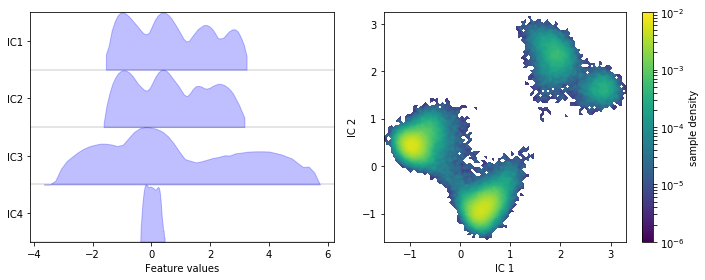

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated1,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3',  'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated1[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

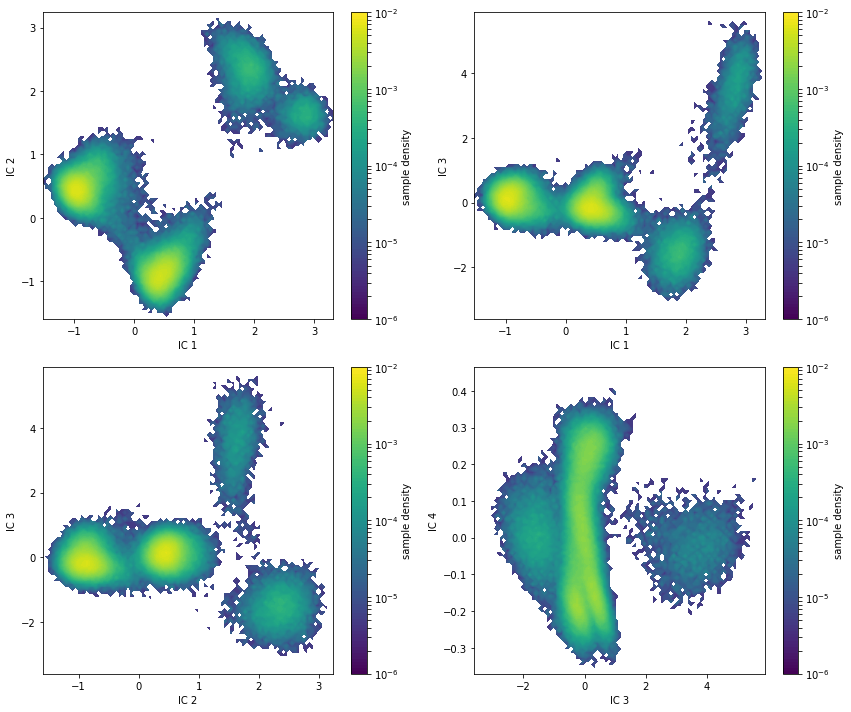

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
pyemma.plots.plot_density(*tica_concatenated1[:, :2:1].T, ax=axes[0,0], logscale=True)
pyemma.plots.plot_density(*tica_concatenated1[:, :3:2].T, ax=axes[0,1], logscale=True)
pyemma.plots.plot_density(*tica_concatenated1[:, 1:3:1].T, ax=axes[1,0], logscale=True)
pyemma.plots.plot_density(*tica_concatenated1[:, 2:4:1].T, ax=axes[1,1], logscale=True)

axes[0,0].set_xlabel('IC 1')
axes[0,0].set_ylabel('IC 2')

axes[0,1].set_xlabel('IC 1')
axes[0,1].set_ylabel('IC 3')

axes[1,0].set_xlabel('IC 2')
axes[1,0].set_ylabel('IC 3')

axes[1,1].set_xlabel('IC 3')
axes[1,1].set_ylabel('IC 4')
fig.tight_layout()

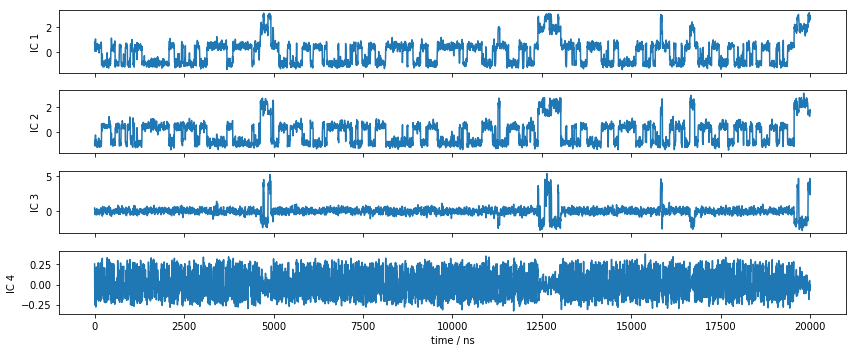

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output1[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output1[0].T)):
    ax.plot(x[::50], tic[::50])
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

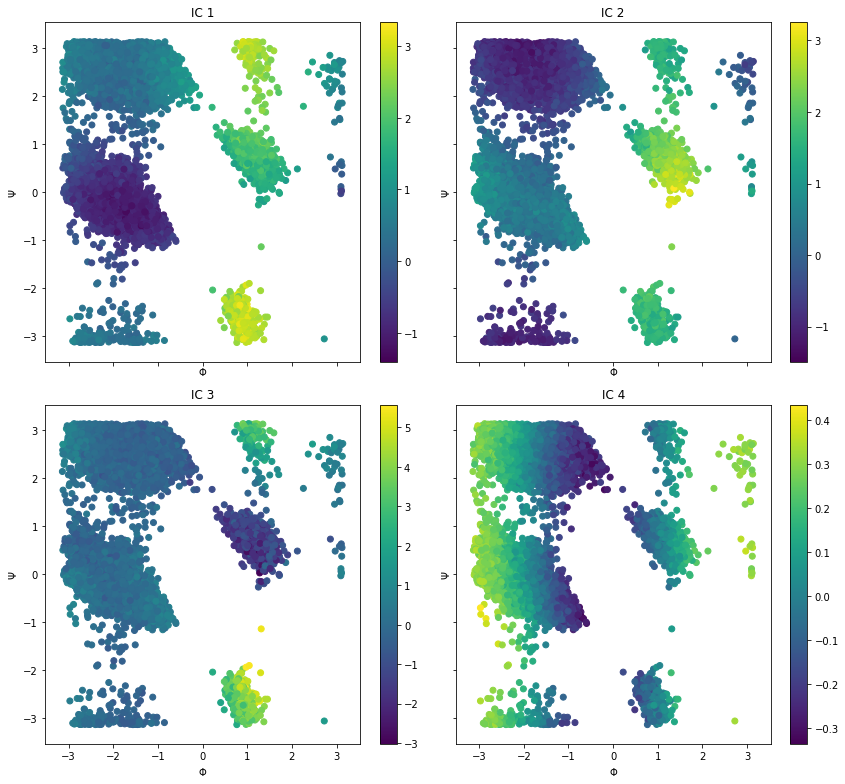

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 11), sharex=True, sharey=True)

for i, (ax, tic) in enumerate(zip(axes.flat, tica_output1[0].T)):
    SC = ax.scatter(data[0][::10,0], data[0][::10,1], c=tic[::10])
    ax.set_title('IC {}'.format(i + 1))
    ax.set_xlabel(r'$\Phi$')
    ax.set_ylabel(r'$\Psi$')
    plt.colorbar(SC, ax=ax)
fig.tight_layout()

## 100 Timestep Lag Time

In [11]:
#Perform the dimensionality reduction, obtain the transform itself
tica = pyemma.coordinates.tica(positions_data, lag=100, dim = 4)

#Load the transformed data into memory
tica_output = tica.get_output()

#Make one concatenated array of transformed data, for graphing purposes
tica_concatenated = np.concatenate(tica_output)


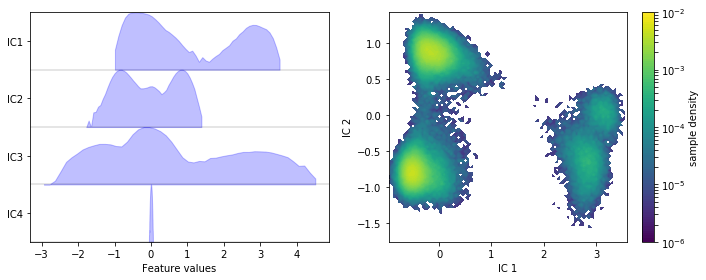

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

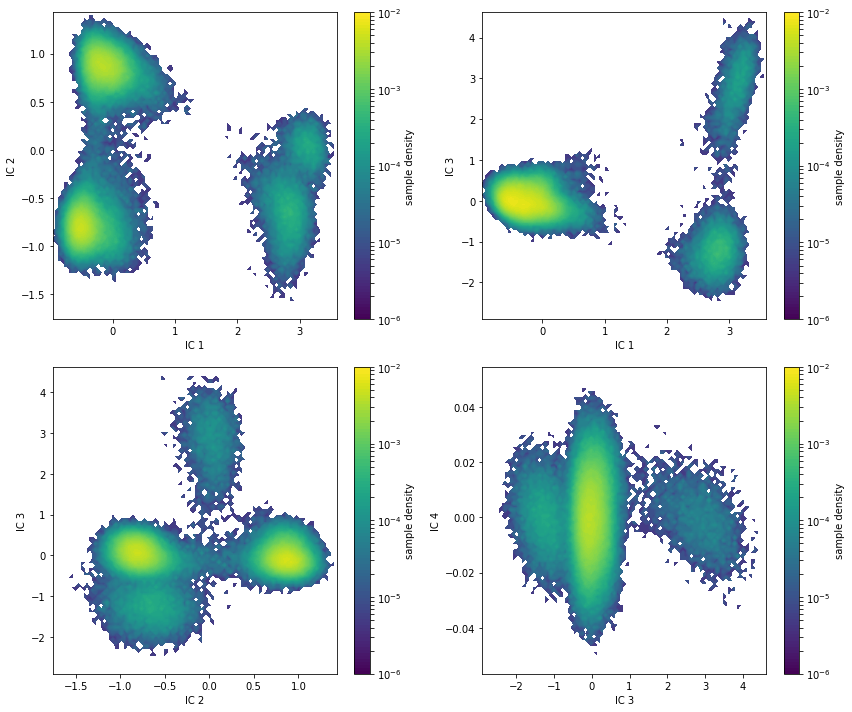

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
pyemma.plots.plot_density(*tica_concatenated[:, :2:1].T, ax=axes[0,0], logscale=True)
pyemma.plots.plot_density(*tica_concatenated[:, :3:2].T, ax=axes[0,1], logscale=True)
pyemma.plots.plot_density(*tica_concatenated[:, 1:3:1].T, ax=axes[1,0], logscale=True)
pyemma.plots.plot_density(*tica_concatenated[:, 2:4:1].T, ax=axes[1,1], logscale=True)

axes[0,0].set_xlabel('IC 1')
axes[0,0].set_ylabel('IC 2')

axes[0,1].set_xlabel('IC 1')
axes[0,1].set_ylabel('IC 3')

axes[1,0].set_xlabel('IC 2')
axes[1,0].set_ylabel('IC 3')

axes[1,1].set_xlabel('IC 3')
axes[1,1].set_ylabel('IC 4')
fig.tight_layout()

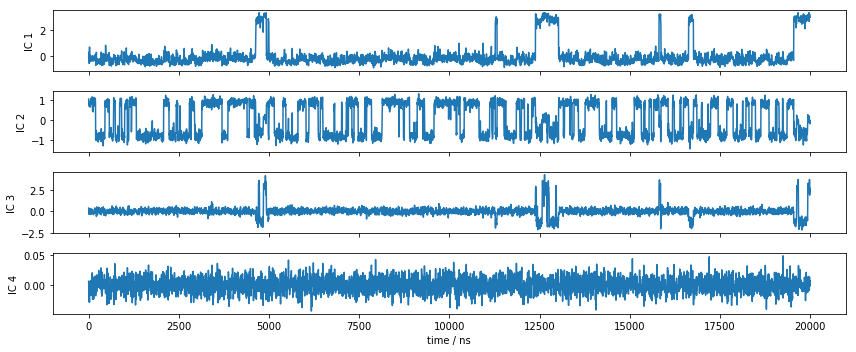

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x[::50], tic[::50])
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

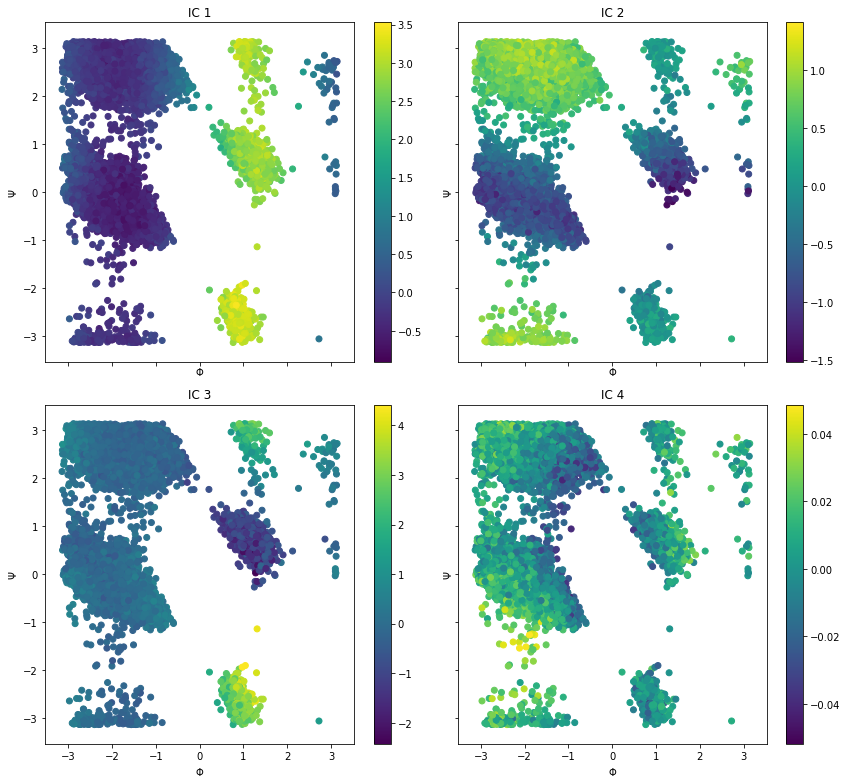

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 11), sharex=True, sharey=True)

for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    SC = ax.scatter(data[0][::10,0], data[0][::10,1] , c=tic[::10])
    ax.set_title('IC {}'.format(i + 1))
    ax.set_xlabel(r'$\Phi$')
    ax.set_ylabel(r'$\Psi$')
    plt.colorbar(SC, ax=ax)
fig.tight_layout()

As you increase the lag time, the eigenvalues for the TICA matrix all decrease. The fourth dominant eigenvalue, specifically, goes to zero between a 20 step and a 100 step delay. You can see that in the fourth eigenvector for the 20 step delay. When projected onto the Ramachandran space, to fourth eigenvector does not correspond to any metastability that you might expect. It seems like the transitions that it describes are relatively fast movements within specific metastable clusters. This is enforced by the trajectory for the fourth TICA coordinate - it seems to be mostly fast movements within a cluster. With a longer lag time, this process is not resolved, as the time-lagged points are too far away to consistently measure a relatively fast transition. I showed the projection into this TIC4 space above, but both the eigenvalue and size of the eigenvector are very small.

Otherwise, the 20 and the 100 timestep lag time both have TICA trajectories that resemble hopping between metastable basins. This is what you would expect from a good dimensionality reduction - the slowest modes of the system are well-captured, which means that trajectories through time should look like relatively sharp transitions between metastable basins. The density projections in TICA space are consistent with Ramachandran space, as they visually preserve the four seemingly-metastable basins that we observed before.  

The first TIC tracks $\Phi$, specifically capturing the transition between the basins at negative $\Phi$s and positive $\Phi$s. The second TIC similarly tracks $\Psi$, capturing the positive to negative transition. The third TIC corresponds to the transition in $\Psi$ for those strucutres that are already in the regime of positive $\Psi$. One can see how the span of these eigenfunctions would capture the types of broad movements of interest in the system.   

Therefore, you should aim to pick a  lag time small enough to capture the slowest modes (*i.e.,* their eigenvalues should not go to zero). However, your lag time should be large enough to actually reduce the dimensionality of the system (*i.e.,* the faster modes should have eigenvalues of zero). How to choose this lag time is often non-trivial, and sometimes requires physical or experimental knowledge of the system, or an idea of the number and types of processes you are trying to model. Many times, you might even have to go back and tweak the TICA inputs once you see the outputs of your MSM. For now, the choice of $\tau = 100$ timesteps seems to best reduce the system to just the slow modes that correspond to transitions between metastable regions. 


# Building the MSM - Discretization

Now that you have an idea of the collective variable space that well describes the process, it is time to build the MSM. Building this MSM relies on being able to systematically discretize parameter space into a series of bins, and then counting transitions between all of these bins. However, the best way to perform this discretization is not immediately obvious. As you can see from your previous density maps, much of our defined parameter space has no sampling, and it would waste a lot of computation time to wait for the system to spontaneously visit these areas. Instead, we want to discretize our CV space by placing a greater density of bins in areas where we have high sampling density. This is the idea behind data clustering, and PyEMMA has multiple built-in functions to do this. 

In this case, use the `pyemma.coordinates.cluster_kmeans()` tool to discretize your TICA output. For grading purposes, make sure to pass `fixed_seed=1` to the k-means algorithm, as it is a stochastic process. Furthermore, note that, in general, the number of clusters/bins to use varies from problem to problem. There are ways to try to quantify the performance of the MSM as you change the number of clusters, but many times the number of clusters is at least partially chosen by visual inspection. Here, 75 clusters should be a reasonable level of discretization. Plot your cluster centers superimposed over your TICA density plots.  How well your clusters cover state space? 

Again, remember to check the PyEMMA tutorials/documentation for examples of syntax on how to do this. 

As a note, remember that you are clustering your TICA output. Thus, this clustering will depend on the optimal TICA lag time that you chose in the previous step. How do you expect the distribution of clusters would change as you increase lag time? 

For the next sections, you can use `cluster.dtrajs` as your new, discretized trajectories, which track the simulation from bin to bin. 

In [16]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=75, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

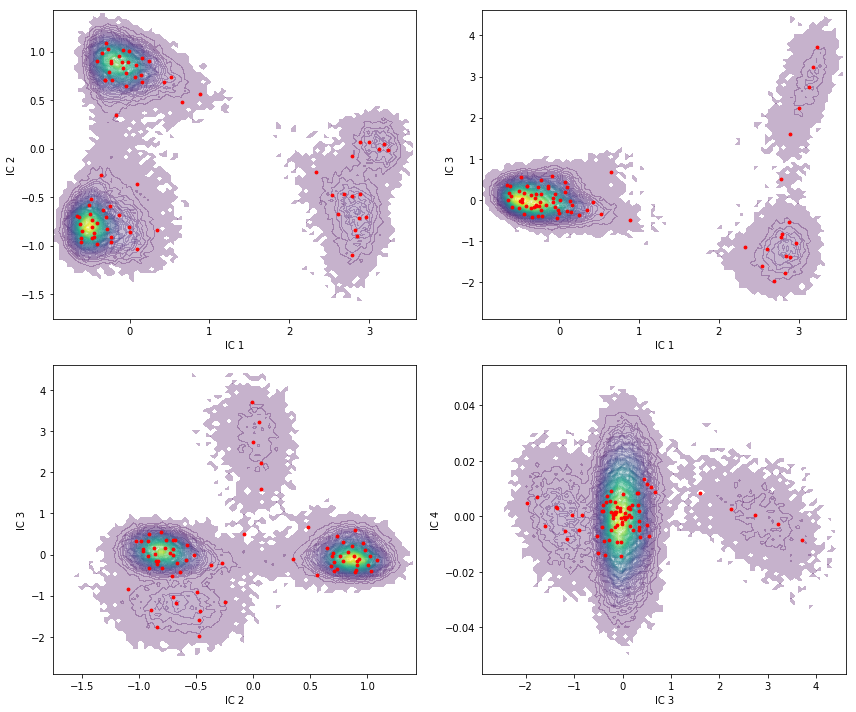

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
pyemma.plots.plot_density(*tica_concatenated[:, :2:1].T, ax=axes[0,0], cbar=False, alpha=0.3)
axes[0,0].scatter(*cluster.clustercenters[:, :2:1].T, s=8, c='r')
pyemma.plots.plot_density(*tica_concatenated[:, :3:2].T, ax=axes[0,1], cbar=False, alpha=0.3)
axes[0,1].scatter(*cluster.clustercenters[:, :3:2].T, s=8, c='r')
pyemma.plots.plot_density(*tica_concatenated[:, 1:3:1].T, ax=axes[1,0], cbar=False, alpha=0.3)
axes[1,0].scatter(*cluster.clustercenters[:, 1:3:1].T, s=8, c='r')
pyemma.plots.plot_density(*tica_concatenated[:, 2:4:1].T, ax=axes[1,1], cbar=False, alpha=0.3)
axes[1,1].scatter(*cluster.clustercenters[:, 2:4:1].T, s=8, c='r')

axes[0,0].set_xlabel('IC 1')
axes[0,0].set_ylabel('IC 2')

axes[0,1].set_xlabel('IC 1')
axes[0,1].set_ylabel('IC 3')

axes[1,0].set_xlabel('IC 2')
axes[1,0].set_ylabel('IC 3')

axes[1,1].set_xlabel('IC 3')
axes[1,1].set_ylabel('IC 4')
fig.tight_layout()

For the 200 timestep lag time, the clusters well cover our sampled areas of collective variable space, as they are well-distributed across the metastable basins, with more clusters appearing in areas of very high density. As the lag time increases, your clusters would trivially follow your changed TICA density projections. They would also change in distribution, as more and more transitions are no longer observed due to the larger and larger timestep, leading to more clusters appearing in high-density regions, and fewer appearing in low-density regions. 

# MSM Lag Time Check - Implied Timescales

The MSM itself, much like TICA, also relies on a lag time, this time to build a MSM transition matrix. When you checked the TICA lag time in a previous section, you first plotted the eigenvalues of the TICA transformation as a function of lag time. We could, in principle, do the same thing here to choose the optimal lag time for the MSM. Instead, we will introduce another type of method that can help determine a good lag time, which is examining the implied timescales (ITs) of the MSM. For any lag time $\tau$, the dominant eigenvalues, $\lambda_i$, of the MSM transition matrix correspond to the slow modes of the system. The timescales of these slow modes can be approximated by the ITs, $t_i$, and are defined as:

$$ t_i = \frac{-\tau}{\ln\left|\lambda_i(\tau)\right|} $$ 

Use `pyemma.msm.its()` and `pyemma.plots.plot_implied_timescales()` to calculate and visualize the top 10 implied timescales as a function of lag time, from 1 to 100 timesteps (0.5 to 50 ps). Make sure to use the `cluster.dtrajs` as your input.

What does this graph tell you? What are desirable features for the ITs to have at a chosen lag time? Specifically, what is the gray shaded region telling you? What are the advantages of using a short lag time? The disadvantages? It might be useful to also visualize this graph in linear space - feel free to try `ax.set_yscale('linear')`.

Use this graph to choose a lag time for your MSM, and justify your choice. 

In [18]:
its = pyemma.msm.its(cluster.dtrajs, lags=100, nits=10, errors='bayes')

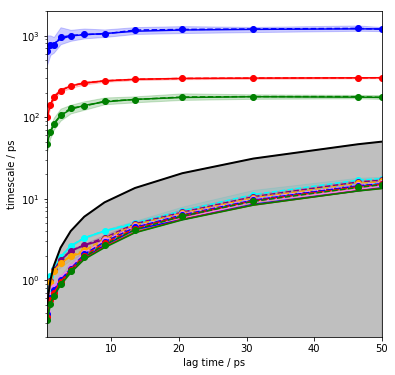

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
pyemma.plots.plot_implied_timescales(its, units='ps', dt=0.5, ax=ax);
#ax.set_yscale('linear')

This graph describes the general timescales for transitions along the dominant TICs, with the assumption that the lag time used to create those TICs best captures the slow modes of the system. As your lag time increases, your dominant 3 ITs rapidly converge, which is desired. If the ITs are converged, then the timescales of transitions between metastable basins are not noticeably changing with a change in lag time. One desires converged ITs, as this reflects that the kinetic information extracted is more likely to be accurate. However, one also wants to maximize the temporal resolution of the MSM. The black shaded region is the area in which we have no resolution, as the implied timescales are below the lag time used. Processes with ITs in this region occur too quickly to be captured by the MSM.

Using this logic, I chose a lag time of 10 ps, or 20 timesteps. In this regime, the three dominant ITs are converged, and the temporal resolution is still high. 

# MSM Validation: Chapman-Kolmogorov Test

Your choice of lag time can be partially validated by the Chapman-Kolmogorov Test. Here, the following relation is evaluated for various integers $k$:

$$ \mathbf{P}(k \tau) = \mathbf{P}^k(\tau) $$

with $\mathbf{P}(\tau)$ being the transition matrix and lag time $\tau$.

Why is this a reasonable test for your MSM to pass? 

Build your MSM by passing your clustered trajectories and chosen lag time to `pyemma.msm.bayesian_markov_model()`. For the number of metastable states suggested by your previous density projections,  run the Chapman-Kolmogorov Test by calling `msm.cktest()`. Make sure to pass in the timestep information (in this case, a 0.5 ps timestep).

What is a reasonable value for the upper value of $k$? Does your MSM built with your chosen lag time pass this test? How can you tell? If it fails, you should rechoose either your TICA lag time or your MSM lag time. 

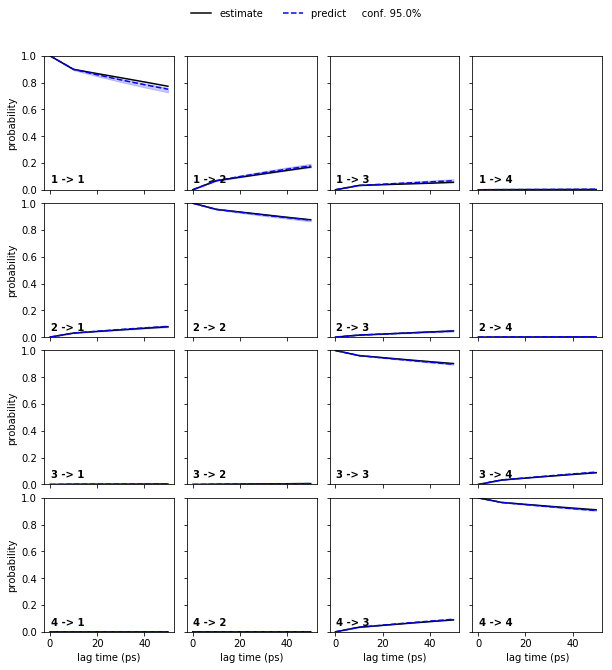

In [20]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=20, dt_traj='0.5 ps')
nstates = 4
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.5, units='ps');

The C-K test works because, for the regime where your MSM transition timescales are resolved, the transition probability matrix should be the same for both $k$ smaller transitions of timestep $\tau$ and one larger transition of timestep  $k \tau$. To combine sequential probabilities, one multiplies them, as normal. For the chosen lag time of 20 timesteps (10 ps), the MSM passes the C-K test, as both sides of the equation agree within a 95% error bound. As long as our ITS are converged and resolved up through a lag time of $k\tau$, the MSM should pass the C-K test. Above that region, $\mathbf{P}(k \tau)$ no longer captures the same dynamics/transitions that $\mathbf{P}(\tau)$ does.

In [35]:
#Save relevent msm objects for Jon
np.save('msm_P.npy', msm.P)
pkl.dump(msm, open("msm.p", "wb" ) )
print(msm.P)

[[0.03556405 0.00133653 0.         ... 0.03058676 0.03098064 0.00134259]
 [0.00090867 0.04367039 0.         ... 0.00038987 0.00025924 0.02093725]
 [0.         0.         0.14239059 ... 0.         0.         0.        ]
 ...
 [0.02495995 0.00046795 0.         ... 0.03931357 0.03744778 0.00061696]
 [0.02411058 0.00029675 0.         ... 0.03571356 0.03720238 0.00089294]
 [0.00162428 0.03725727 0.         ... 0.00091467 0.00138811 0.02128644]]


In [34]:
#Test to make sure you can re-load them
msm_test = pkl.load(open("msm.p", "rb" ))
print(msm_test.P)

[[0.03556405 0.00133653 0.         ... 0.03058676 0.03098064 0.00134259]
 [0.00090867 0.04367039 0.         ... 0.00038987 0.00025924 0.02093725]
 [0.         0.         0.14239059 ... 0.         0.         0.        ]
 ...
 [0.02495995 0.00046795 0.         ... 0.03931357 0.03744778 0.00061696]
 [0.02411058 0.00029675 0.         ... 0.03571356 0.03720238 0.00089294]
 [0.00162428 0.03725727 0.         ... 0.00091467 0.00138811 0.02128644]]


# Extracting Kinetic Quantities from the MSM

In this section, you will use your newly-created MSM to determine the flux network that connects certain metastable basins. To do this, you will first define those metastable basins, then use Transition Path Theory to determine the connectivity between them. 

First, using the syntax in the tutorials and `msm.eigenvectors_right()`, visualize the top 3 (non-trivial) eigenvectors of your MSM transition matrix. What do they correspond to? 

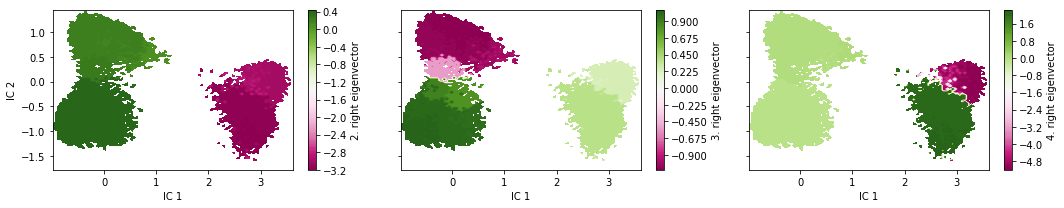

In [25]:
eigvec = msm.eigenvectors_right()

fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

These eigenvectors correspond to the transitions between metastable basins, which correspond to areas of dense sampling, as previously discussed. 

## Finding Metastable Regions - Perron Cluster Cluster Analysis (PCCA)

Up until now, we have referenced the metastable sets apparent in our density plots, but we have not defined what they area. [PCCA++](http://docs.markovmodel.org/lecture_pcca.html) uses an effective clustering in eigenvector space, visualized in the previous section, to assign the probability of a certain configuration belonging to a given macrostate (metastable state). 

Use the `metastable_distributions` of your MSM to plot the distributions of each point in you TICA output belonging to a certain metastable state. From there, use the `metastable_assignments` to formally assign each point to a certain metastable state. Syntax examples for this process are available in the tutorial.

Also, color your dihedral/Ramachandran plot by the metastable state assignments (this will be a similar code to the visualization of this same data colored by your TICA eigenvectors). How well does PCCA++ resolve your apparent metastable states in either space?

In [26]:
msm.pcca(nstates)

PCCA(P=array([[0.03626, 0.00133, ..., 0.03111, 0.00134],
       [0.00091, 0.04367, ..., 0.00026, 0.02094],
       ...,
       [0.02423, 0.0003 , ..., 0.03716, 0.00089],
       [0.00162, 0.03726, ..., 0.00139, 0.02129]]),
   m=4)

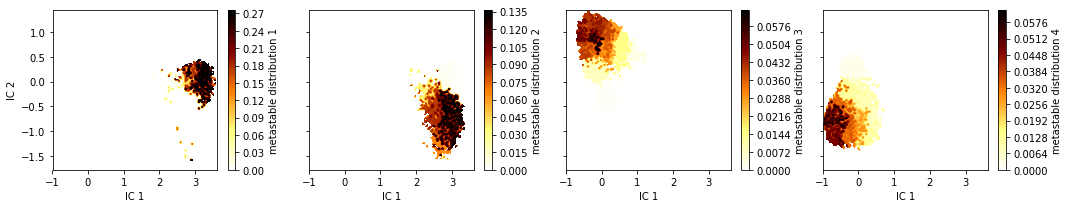

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

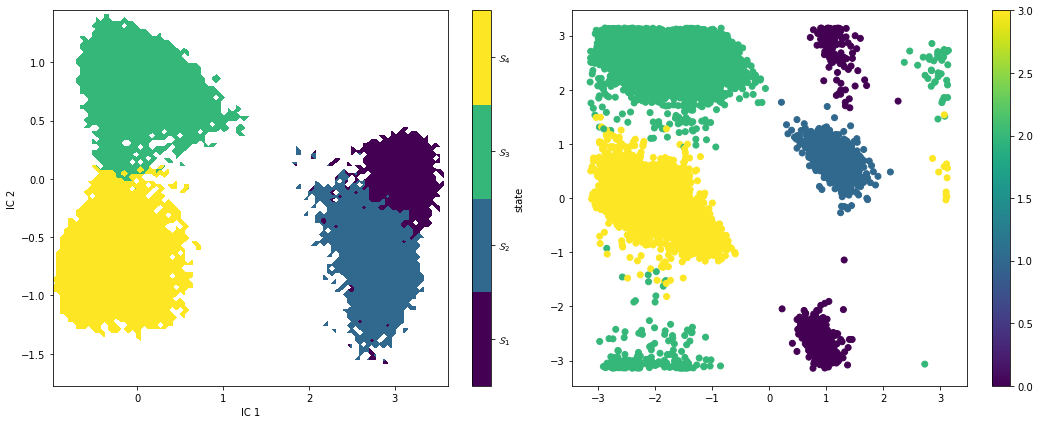

In [28]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(1,2, figsize=(15, 6))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax[0])
ax[0].set_xlabel('IC 1')
ax[0].set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])

SC = ax[1].scatter(data[0][::10,0], data[0][::10,1] , c=metastable_traj[::10])
plt.colorbar(SC, ax=ax[1])
fig.tight_layout()

The PCCA decomposes the metastable sets very well, both in TICA space and in Ramachandran space

Use the following code to grab sample `.pdb` strcutures from each metastable set. Use VMD to visualize these structures - are these structures consistent with your metastable state assignments? 

In [29]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
torsions_source = pyemma.coordinates.source(dfile, features=feat)
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=['./MSM_data/pcca{}_10samples.pdb'.format(n + 1)
              for n in range(msm.n_metastable)])

['./MSM_data/pcca1_10samples.pdb',
 './MSM_data/pcca2_10samples.pdb',
 './MSM_data/pcca3_10samples.pdb',
 './MSM_data/pcca4_10samples.pdb']

Yes!

## Transition Path Theory (TPT) - Committors

[TPT](https://cims.nyu.edu/~eve2/tpt_erice.pdf) is a powerful theoretical framework that allows you to extract various kinetic quantities of interest, like mean first-passage times, rates, commitment probabilities, and reactive pathways. While the specifics of TPT are beyond the scope of this module, I encourage you to look through the attributes in the MSM object to see the types of quantities one can calculate. 

In this module, we will be investigating the committor function. The committor is the probability of entering some set A before entering another disjoint set B, as a function of the state of your system. For example, if you are considering a protien folding problem, you can define one set as the unfolded protein, and another as the native folded protein. Your committor function would then describe the probability of folding throughout state space.

Here, you should plot the committor between the various metastable sets you have defined previously (see tutorial). Going back to the very first section of the model, we said we were interested in finding the mechanism of transition between the left central cluster and the lower right cluster in dihedral/Ramachandran space. What does the graph of that committor initially tell you about this mechanism? 


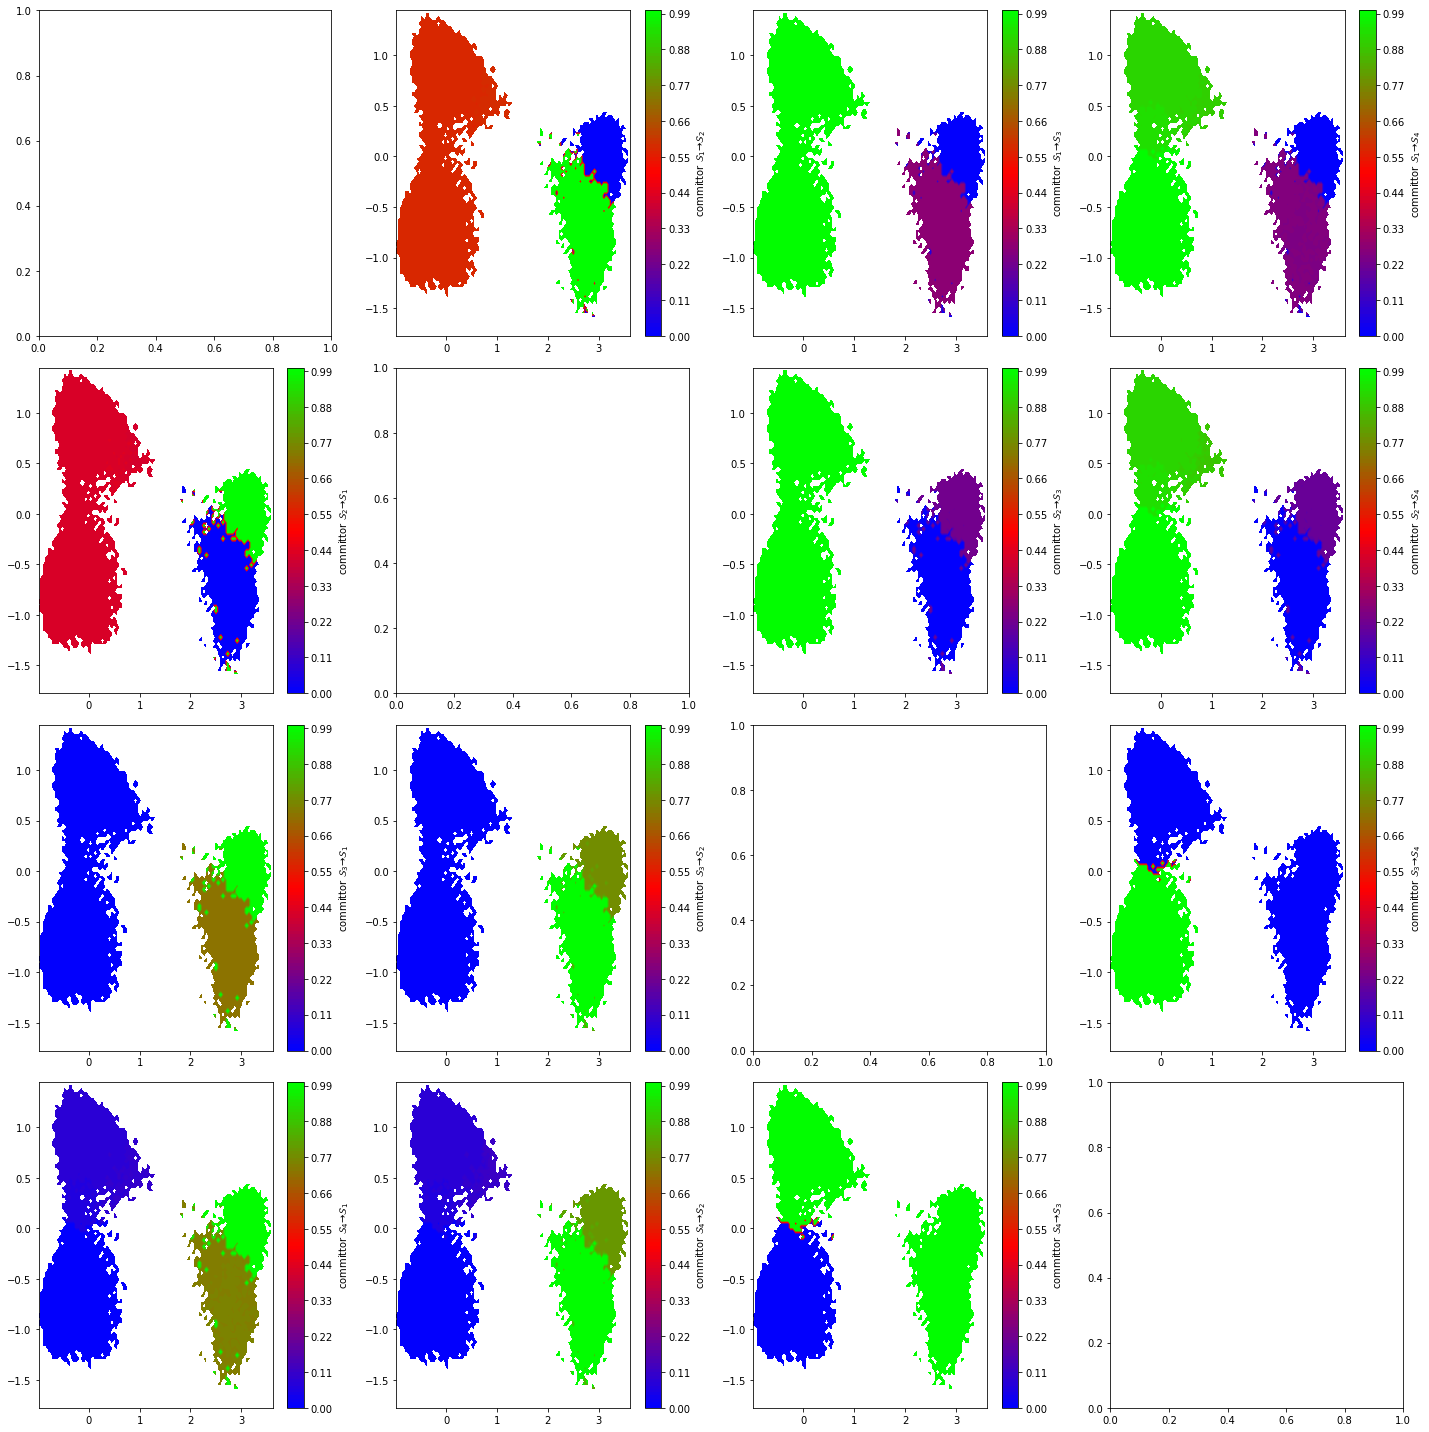

In [30]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    start, final = divmod(i, 4)
    if start==final: continue
    A = msm.metastable_sets[start]
    B = msm.metastable_sets[final]
    flux = pyemma.msm.tpt(msm, A, B)
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        flux.committor[dtrajs_concatenated],
        cmap='brg',
        ax=ax,
        mask=True,
        cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (start + 1, final + 1))
fig.tight_layout()
plt.show()


The committor of interest (between clusters 4 and 1) is in the lower left corner of the above plot. It is zero inside of cluster 4, and 1 inside of cluster 1, which is as expected. Otherwise, the probability of observing the transition increases slightly as you move to the cluster above it in TICA space, and increases dramatically once you move to cluster 2. This corresponds to making a sharp transition in $\Phi$. However, the mechanism is still unclear.

## Coarse-Graining The Committor

One can integrate over the committor to define overall probability fluxes for transitions between our previously defined metastable sets. PyEMMA has a nice implementation of this, as well as a plotting function that displays this coarse-graining as a flux network. Make a graph of this network, and rationalize what you see. From this, describe the mechanism for our desired transition. 

The network that you create here should look relatively simple, but remember that it depended on quite a few internal parameters - TICA lag time, MSM lag time, number of cluster centers, etc. Make at least one change in your lag time(s), and compare the resulting flux network. Rationalize your observations. What would you expect the committors to be for an infinite MSM lag time? 

(<Figure size 864x276.48 with 1 Axes>, array([[0.        , 0.23      ],
        [0.74996541, 0.23      ],
        [0.08144963, 0.55      ],
        [1.        , 0.55      ]]))

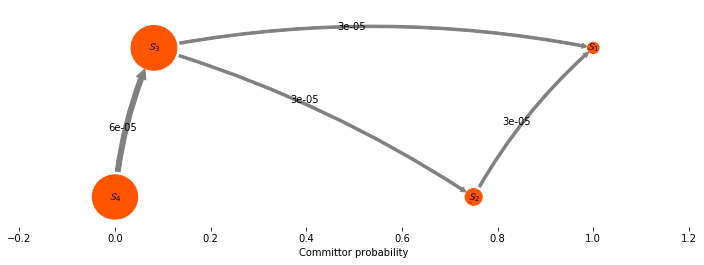

In [36]:
start, final = 3, 0
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

posx = cgflux.forward_committor
posy = 0.1 * np.array([2.3, 2.3, 5.5, 5.5])
pos = np.vstack([posx, posy]).T

pyemma.plots.plot_flux(
    cgflux, pos=pos,
    show_committor=True,
    state_labels = [r'$\mathcal{S}_4$', r'$\mathcal{S}_2$', r'$\mathcal{S}_3$', r'$\mathcal{S}_1$'])


This network suggests that the mechanism is as follows. Starting from a $\Psi$ dihedral near 0, and a $\Phi$ dihedral near -2, the $\Phi$ dihedral first increases to around 2.5 radians. From there, it can either couple a $\Phi$ rotation to a $\Psi$ rotation to move directly into cluster one, or it can first rotate $\Phi$ and then rotate $\Psi$. It takes these paths with approximately equal probability. The committor doesn't change much between cluster 4 and cluster 3, suggesting that the ADP is only likely to change configuration once a $\Phi$ rotation occurs

# Repeating With a Shorter Lag Time

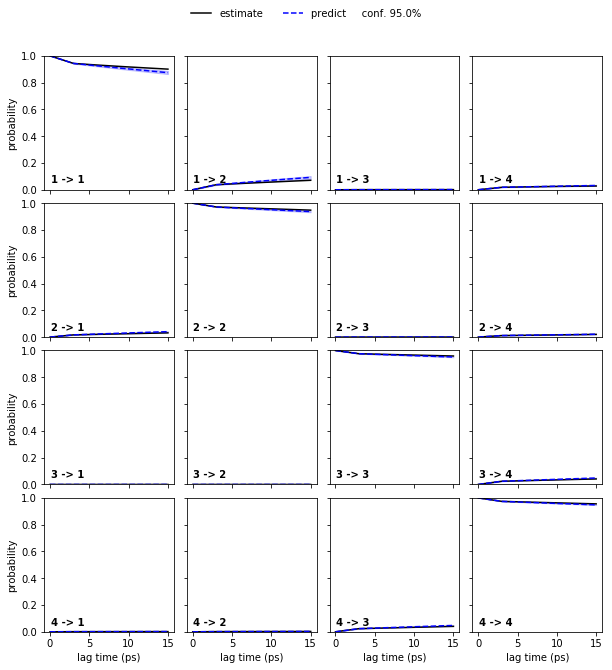

In [326]:
#Performing the clustering on our 20 timetep time-lagged TICA output (we used 100 stimesteps before)
cluster1 = pyemma.coordinates.cluster_kmeans(
    tica_output1, k=75, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated1 = np.concatenate(cluster1.dtrajs)

#Change the lag time to 6 timesteps, of 3 ps (we were using 10 ps before)
msm1 = pyemma.msm.bayesian_markov_model(cluster1.dtrajs, lag=6, dt_traj='0.5 ps')
nstates = 4
cktest1 = msm1.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest1, dt=0.5, units='ps');

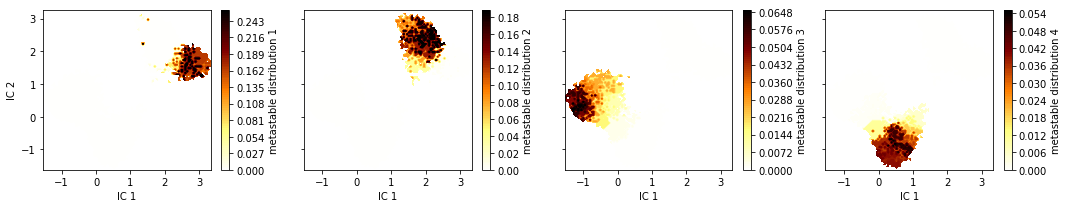

In [327]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated1[:, :2].T,
        msm1.metastable_distributions[i][dtrajs_concatenated1],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

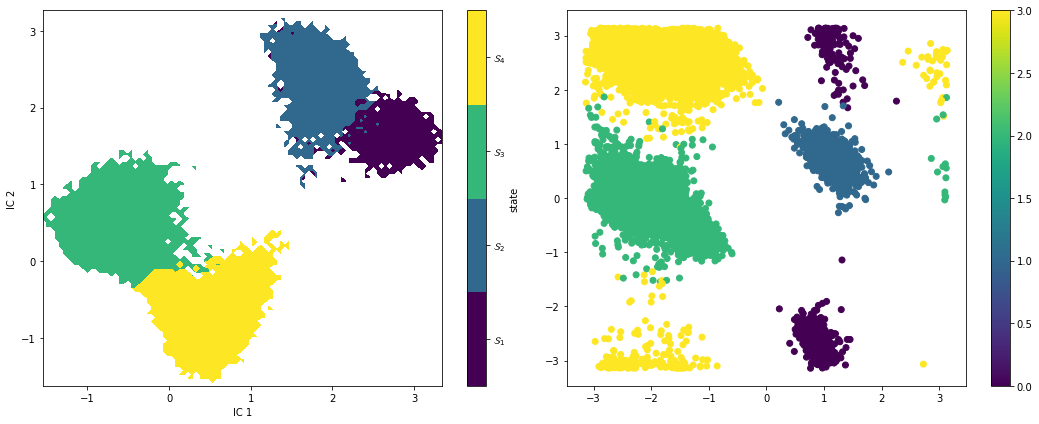

In [339]:
metastable_traj1 = msm1.metastable_assignments[dtrajs_concatenated1]

fig, ax = plt.subplots(1,2, figsize=(15, 6))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated1[:, :2].T, metastable_traj1, ax=ax[0])
ax[0].set_xlabel('IC 1')
ax[0].set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])

SC = ax[1].scatter(data[0][::10,0], data[0][::10,1] , c=metastable_traj1[::10])
plt.colorbar(SC, ax=ax[1])
fig.tight_layout()

(<Figure size 864x276.48 with 1 Axes>, array([[0.       , 0.23     ],
        [0.8146931, 0.23     ],
        [0.0685637, 0.55     ],
        [1.       , 0.55     ]]))

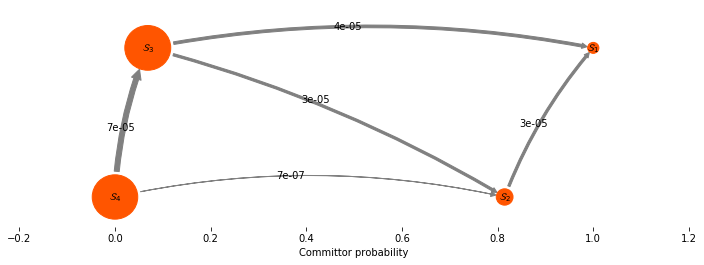

In [342]:
start1, final1 = 2, 0
A1 = msm1.metastable_sets[start1]
B1 = msm1.metastable_sets[final1]
flux1 = pyemma.msm.tpt(msm1, A1, B1)

cg1, cgflux1 = flux1.coarse_grain(msm1.metastable_sets)

posx = cgflux1.forward_committor
posy = 0.1 * np.array([[2.3, 2.3, 5.5, 5.5]])
pos = np.vstack([posx, posy]).T

pyemma.plots.plot_flux(
    cgflux1, pos=pos,
    show_committor=True,
    state_labels = [r'$\mathcal{S}_4$', r'$\mathcal{S}_2$', r'$\mathcal{S}_3$', r'$\mathcal{S}_1$'])

As you decreased the TICA and MSM lag time to capture the fourth slowest mode, we gained a probability flux between cluster 4 and 2, although it is small. Otherwise, very little else has changed. This suggests that TICA4 was likely a very fast mode that primarily occurred within the metastable basins, and thus was not very important to model. Notice, however, that the fluxes do change with this relatively small change in lag time. This suggests that MSMs are very sensitive to these types of changes in hyperparameters. Thus, especially as one expands to more complex systems, the choice of lag time and clustering becomes vitally important. 

As the MSM lag time approaches infinity, one would expect the committor to be 1 within the destination set, 0 within the starting set by construction. In other regions, the committor should be ratio of Boltzmann weights (determined by their free energy) for the two sets in question. This is because at a given infinitely large time lag, the probability of being in any given set approached equilibrium, defined by the Boltzmann distribution. 